In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

In [2]:
import os
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import pickle
from collections import defaultdict

from skimage.segmentation import mark_boundaries
from glob import glob
import pandas as pd
import scipy
import cv2
import joblib

from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
import torch
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F

In [4]:
import sys
sys.path.append('../torch_utils/')
sys.path.append('../utils')
sys.path.append('../zoo')
import rles
import dataset as ds
%load_ext autoreload
%autoreload 2
import ternaus_net
%load_ext autoreload
%autoreload 2
import enorm
%load_ext autoreload
%autoreload 2
import augmentations as augs
%load_ext autoreload
%autoreload 2
import learner as lrnr
%load_ext autoreload
%autoreload 2
import torch_funcs as thf
%load_ext autoreload
%autoreload 2
import losses
import metrics
import visualisation
import nms
%load_ext autoreload
%autoreload 2
import map_iou

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
PATHS = {
    'DATA': '../data/',
    'MASKS': '../data/masks/',
    'ARCHIVE': '../data/indianapolis/',
    'TRAIN': '../data/train',
    'TEST': '../data/test',
    'CSV': '../data/csv',
}

PARAMS = {
    'PATHS': PATHS,
    'SEED': 42,
    'NB_FOLDS': 4,
    'PNG_SIDE': 512,
    'CUDA_DEVICES': [0, 1],
    'INVERSE': 3,
    'BATCH_SIZE': 12,
    'NB_EPOCHS': 14,
    'LR': 2e-4,
    'EXP_GAMMA': .98,
    'CUDA_DEVICES': [0, 1],
}

In [6]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [7]:
polyp_detection = { 
#     'TP': [9495, 12193, 11059, 8822, 8277, 10152, 9963, 3448, 9471, 10174, 10449, 11060],
#     'FP': [799, 4440, 3923, 1097, 934, 829, 860, 11, 1416, 3206, 2094, 2531],
#     'TN': [5342, 1701, 2218, 5044, 5207, 5312, 5281, 6130, 4725, 2935, 4047, 3610],
#     'FN': [3097, 399, 1533, 3770, 4315, 2440, 2629, 9144, 3121, 2418, 2143, 1532],
    'Prec': [92.24, 73.31, 73.82, 88.94, 89.86, 92.45, 92.05, 99.68, 86.99, 76.04, 83.31, 81.38],
    'Rec': [75.41, 96.83, 87.83, 70.06, 65.73, 80.62, 79.12, 27.38, 75.21, 80.80, 82.98, 87.83],
    'Spec': [86.99, 27.70, 36.12, 82.14, 84.79, 86.50, 86.00, 99.82, 76.94, 47.79, 65.90, 58.79],
    'Accuracy': [79.20, 74.17, 70.87, 74.02, 71.98, 82.55, 81.38, 51.13, 75.78, 69.68, 77.38, 78.31],
    'F1': [82.98, 83.44, 80.21, 78.38, 75.93, 86.13, 85.10, 42.96, 80.68, 78.35, 83.14, 84.48],
    'F2': [78.26, 90.99, 84.61, 73.17, 69.46, 82.74, 81.41, 32.03, 77.31, 79.80, 83.05, 86.46],
}

polyp_detection = pd.DataFrame(polyp_detection)
harvest = polyp_detection.corr().values

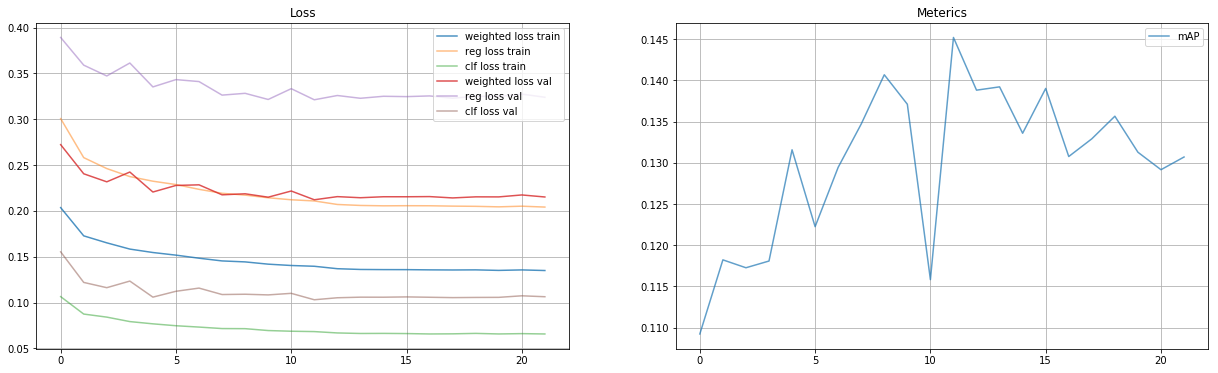

In [57]:
checkpoints_pth = '../data/models/retinanet/'
l = pickle.load(open('../data/models/retinanet_resnet101_no_clf_last_____lr_pure_decay_from_epoch_11/fold_0_checkpoint.epoch_loss', 'rb'))
visualisation.plot_retina_losses(l);

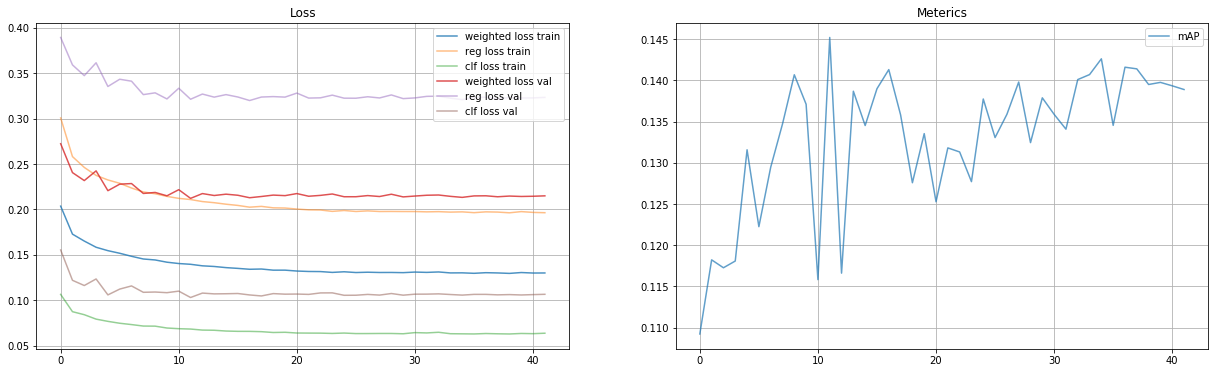

In [56]:
checkpoints_pth = '../data/models/retinanet/'
l = pickle.load(open('../data/models/retinanet_resnet101_no_clf_last_____lr_pure_decay/fold_0_checkpoint.epoch_loss', 'rb'))
visualisation.plot_retina_losses(l);

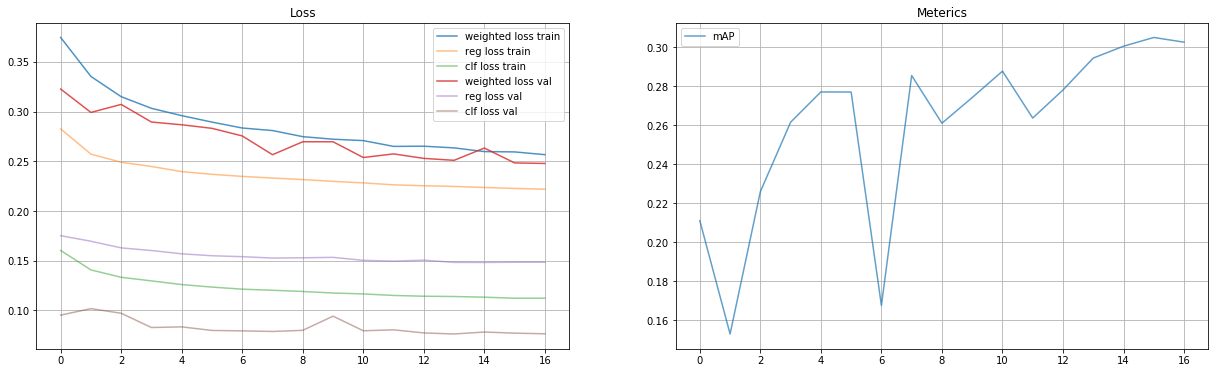

last_epoch: 15


In [11]:
fold=3
checkpoints_pth = '../data/models/retinanet_resnet101'
history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']])
last_epoch = max(15, last_epoch)

visualisation.plot_retina_losses(history)
print('last_epoch: {}'.format(last_epoch))

In [ ]:
bbxr, clfr = pickle.load(open('../data/models/retinanet_resnet50_no_clf/fold_0_checkpoint.epoch_results_30', 'rb'))
# bbxr, clfr = pickle.load(open('../data/models/retinanet_34_clf/fold_1_checkpoint.epoch_results', 'rb'))

In [ ]:
torch.optim.lr_scheduler.StepLR()

In [10]:
df = pd.read_csv(os.path.join(PATHS['CSV'], 'stage_1_train_labels.csv'))
df = df.dropna().drop(['Target'], axis=1)
df[['x', 'y', 'width', 'height']] /= 2

df.head()

,patientId,x,y,width,height
4,00436515-870c-4b36-a041-de91049b9ab4,132.0,76.0,106.5,189.5
5,00436515-870c-4b36-a041-de91049b9ab4,281.0,76.0,128.0,226.5
8,00704310-78a8-4b38-8475-49f4573b2dbb,161.5,288.5,80.0,52.0
9,00704310-78a8-4b38-8475-49f4573b2dbb,347.5,287.5,81.0,68.5
14,00aecb01-a116-45a2-956c-08d2fa55433f,144.0,161.0,47.0,67.5


In [11]:
import numpy as np


# Malisiewicz et al.
def non_max_suppression_fast(boxes, score, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return [], []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        widxs = np.where(overlap > overlapThresh)[0].tolist() + [last]
#         print(widxs)
    
        pick.append(idxs[widxs[np.argmax(score[widxs])]])

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, widxs)

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int"), pick


In [12]:
def visualize_bboxes(img, pred, category_id_to_name={1: 'pnm'}):
    plt.figure(figsize=(10, 10))
    for idx, bbox in enumerate(pred):
        img = visualisation.visualize_bbox(img.copy(), bbox, 1, category_id_to_name)
    plt.imshow(img)
    plt.show()

In [13]:
def compute_maps(df, bbxr, clfr, k=2, coeff=.2):
#     print(np.sum(np.argmax(clfr, axis=1) == 1) / clfr.shape[0])
#     dist = np.bincount(np.argmax(clfr, axis=1))
    counter = 0
    max_score = [max([pred['score'] for pred in patient]) for patient in bbxr]
    threshold = sorted(max_score, reverse=True)[int(len(bbxr) * coeff)]
    print(threshold)
    mAPs = list()
    for pid, sample in tqdm(enumerate(bbxr)):
        key = sample[0]['image_id'].split('.')[0]
        annot = df.query('patientId==@key').drop(['patientId'], axis=1).values.astype(np.int)
        annot[:, 2] += annot[:, 0]
        annot[:, 3] += annot[:, 1]

        if 'bbox' in sample[0].keys():
            ssm = True #float(torch.nn.functional.softmax(torch.tensor(clfr[pid]))[1].data.numpy()) > .15
            top_k_annots = np.array([k['bbox'] for k in sample if (k['score'] * ssm) > threshold], dtype=int)
            score = np.array([k['score'] for k in sample if (k['score'] * ssm) > threshold])

            top_k_annots, idxs = nms.non_max_suppression_fast(top_k_annots, overlapThresh=.5)
#             top_k_annots, idxs = non_max_suppression_fast(top_k_annots, score, overlapThresh=.5)
            
            score = score[idxs]

            idxs = np.arange(len(top_k_annots)).tolist()
            idxs = sorted(idxs, key=lambda i: score[i], reverse=True)[:k +1]
            top_k_annots = np.array(top_k_annots)
            top_k_annots = top_k_annots[idxs]
            score = score[idxs]
            if len(annot) or len(top_k_annots):
                counter += 1
            if counter % 200 == 0:
                counter += 1
                clear_output(wait=True)
                img = cv2.imread(os.path.join(PATHS['TRAIN'], 'png', key + '.dcm.png'))
                visualize_bboxes(img, top_k_annots)
                visualize_bboxes(img, annot)
#                 print('Clfs\t: norm: %.3f, pnm: %.3f, exl: %.3f' % tuple(v['clfs'].tolist()))
                print('Scores\t:', score)
                print('BBoxes\t:', top_k_annots)
        else:
            top_k_annots = np.zeros((0, 4))
            score = []
        mAPs.append(map_iou.map_iou(annot, top_k_annots, score))
    return np.mean([mAP for mAP in mAPs if mAP is not None]), threshold


In [ ]:
compute_maps(df, bbxr, clfr, coeff=.32, k=2)

In [ ]:
mpaths = glob(os.path.join(PATHS['TRAIN'], 'png', '*.png'))
ipaths = glob(os.path.join(PATHS['TRAIN'], 'png', '*.png'))

separate = lambda x: os.path.basename(x)
ipaths = [separate(path) for path in ipaths]
mpaths = [separate(path) for path in mpaths]

paths = list(set(mpaths).intersection(ipaths))
paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)

In [146]:
ddf = pd.read_csv(os.path.join(PATHS['CSV'], 'stage_1_detailed_class_info.csv'))
ddf = ddf.drop_duplicates().reset_index(drop=True)
mapper = {
    'No Lung Opacity / Not Normal': 2, 
    'Lung Opacity': 1, 
    'Normal': 0
}
ddf['class'] = ddf['class'].apply(lambda x: mapper[x])
ddf.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,2
2,00322d4d-1c29-4943-afc9-b6754be640eb,2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [17]:
def compute_maps(df, bbxr, clfr=None, k=2, coeff=None, iou_thresh=.3):
    if coeff is None:
        coeff = np.sum(np.argmax(clfr, axis=1) == 1) / clfr.shape[0]
        dist = np.bincount(np.argmax(clfr, axis=1))

    max_score = [max([pred['score'] for pred in patient]) for patient in bbxr]
    threshold = sorted(max_score, reverse=True)[int(len(bbxr) * coeff)]

    mAPs = list()
    for pid, sample in tqdm(enumerate(bbxr)):
        key = sample[0]['image_id'].split('.')[0]
        annot = df.query('patientId==@key').drop(['patientId'], axis=1).values.astype(np.int)
        annot[:, 2] += annot[:, 0]
        annot[:, 3] += annot[:, 1]

        if 'bbox' in sample[0].keys():
            scores_over_thresh = np.array([k['score'] > .05 for k in sample if k['score']])
            uzft = np.array([
                np.concatenate([
                    [k['score']], k['bbox']
                ], axis=0) 
                if len(k['bbox']) else
                np.zeros((5, ))
                for k in sample
            ])[scores_over_thresh]
            uzft = np.concatenate([np.ones((uzft.shape[0], 1)), uzft], axis=1)

            chosen = list()

            if len(uzft):
                for i in range(4):
                    ref_bbx = uzft[np.argmax(uzft[:, 1])]
                    if ref_bbx[1] < threshold:
                        break
                    zious = np.array([map_iou.iou(ref_bbx[2:], u[2:]) for u in uzft])
                    selected = uzft[zious > .55]
                    
#                     selected = (selected[:, 2:] * selected[:, 1:2]).sum(axis=0) / selected[:, 1].sum()

                    selected = ref_bbx[2:]
                    chosen.append(np.concatenate([ref_bbx[:2], selected]))
                    uzft = uzft[zious < iou_thresh]
                    if len(uzft) == 0:
                        break
                chosen = np.array(chosen)
            if (not len(uzft)) or (not len(chosen)):
                top_k_annots = np.zeros((0, 4))
                score = []
            else:
                top_k_annots = chosen[:, 2:]
                score = chosen[:, 1]
        else:
            top_k_annots = np.zeros((0, 4))
            score = []
        mAPs.append(map_iou.map_iou(annot, top_k_annots, score))
    return np.mean([mAP for mAP in mAPs if mAP is not None]), threshold


Fold: 1


6421it [00:19, 337.39it/s]
6421it [00:16, 395.61it/s]
6421it [00:19, 335.43it/s]
1285it [00:03, 413.97it/s]
1285it [00:03, 371.57it/s]
1285it [00:03, 356.19it/s]
1285it [00:03, 366.06it/s]
1285it [00:03, 358.33it/s]
1285it [00:03, 380.23it/s]
1285it [00:03, 416.79it/s]
1285it [00:03, 413.76it/s]
1285it [00:03, 385.23it/s]
1285it [00:03, 386.78it/s]
1285it [00:03, 412.06it/s]
1285it [00:03, 372.76it/s]
1285it [00:03, 390.67it/s]
1285it [00:02, 429.25it/s]
1285it [00:03, 403.77it/s]
1285it [00:03, 405.77it/s]
1285it [00:03, 420.32it/s]
1285it [00:02, 429.52it/s]
1285it [00:03, 377.57it/s]


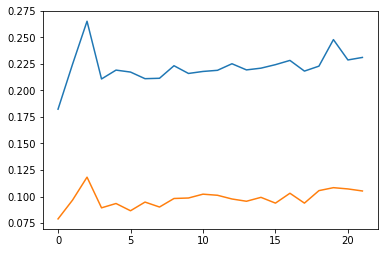

Fold: 2


6421it [00:18, 354.94it/s]
6421it [00:18, 339.26it/s]
6421it [00:17, 358.89it/s]
6421it [00:20, 319.02it/s]
6421it [00:19, 326.91it/s]
6421it [00:19, 321.77it/s]
6421it [00:18, 352.07it/s]
6421it [00:18, 349.87it/s]
6421it [00:16, 380.07it/s]
6421it [00:17, 358.81it/s]
6421it [00:18, 346.16it/s]
6421it [00:17, 374.58it/s]
6421it [00:17, 365.62it/s]
6421it [00:17, 373.66it/s]
6421it [00:17, 366.14it/s]
1285it [00:03, 338.12it/s]
1285it [00:03, 341.91it/s]
1285it [00:03, 416.34it/s]
1285it [00:03, 330.79it/s]
1285it [00:03, 337.57it/s]
1285it [00:03, 419.13it/s]
1285it [00:03, 322.47it/s]


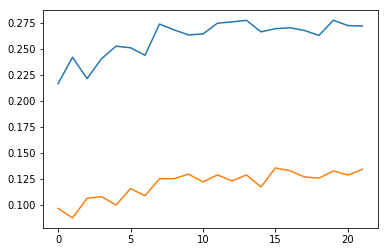

Fold: 3


6421it [00:19, 337.50it/s]
6421it [00:21, 299.53it/s]
6421it [00:20, 320.19it/s]
6421it [00:24, 263.76it/s]
6421it [00:23, 275.59it/s]
6421it [00:27, 237.77it/s]
6421it [00:23, 278.21it/s]
6421it [00:24, 266.44it/s]
6421it [00:22, 291.11it/s]
6421it [00:21, 292.07it/s]
6421it [00:22, 289.85it/s]
6421it [00:21, 296.38it/s]
6421it [00:21, 300.72it/s]
6421it [00:22, 288.38it/s]
6421it [00:21, 304.39it/s]
1285it [00:02, 440.47it/s]
1285it [00:02, 445.34it/s]
1285it [00:03, 418.15it/s]


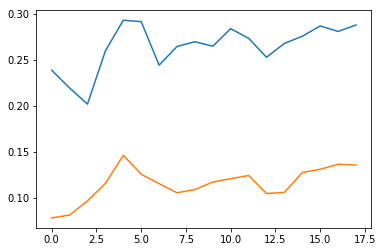

In [17]:
NB_EPOCH = 17
base_pth = '../data/models/retinanet_resnet50_no_clf_last/'

for fold in range(1, 4):
    print('Fold: {}'.format(fold))
    l = pickle.load(open(os.path.join(base_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
    plt.plot([ls['iou'] for ls in l['val_losses']])
    for epoch, el in enumerate(l['val_losses']):
        bbxr, clfr = pickle.load(open(os.path.join(base_pth, 'fold_{}_checkpoint.epoch_results_{}'.format(fold, epoch)), 'rb'))
        iou = map_iou.compute_maps(df, bbxr, clfr, coeff=.22, k=2)
        l['val_losses'][epoch]['iou'] = iou[0]
    plt.plot([ls['iou'] for ls in l['val_losses']])
    plt.show()
#     pickle.dump(l, open(os.path.join(base_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'wb'))


Fold: 0


6421it [00:14, 455.28it/s]
6421it [00:13, 480.32it/s]
6421it [00:13, 470.33it/s]
6421it [00:13, 458.91it/s]
6421it [00:13, 475.18it/s]
6421it [00:13, 474.28it/s]
6421it [00:13, 485.77it/s]
6421it [00:13, 470.80it/s]
6421it [00:13, 467.79it/s]
6421it [00:13, 487.02it/s]
6421it [00:13, 486.60it/s]
6421it [00:14, 458.49it/s]
6421it [00:13, 468.73it/s]
6421it [00:13, 466.61it/s]
6421it [00:13, 474.14it/s]
6421it [00:12, 516.57it/s]
6421it [00:14, 455.23it/s]


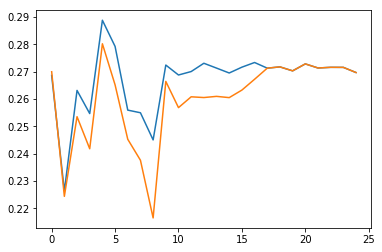

Fold: 1


6421it [00:13, 465.19it/s]
6421it [00:15, 422.08it/s]
6421it [00:15, 411.17it/s]
6421it [00:15, 426.51it/s]
6421it [00:14, 452.19it/s]
6421it [00:14, 450.64it/s]
6421it [00:15, 418.42it/s]
6421it [00:14, 440.06it/s]
6421it [00:14, 429.77it/s]
6421it [00:13, 461.18it/s]
6421it [00:14, 434.15it/s]
6421it [00:14, 436.17it/s]
6421it [00:13, 486.78it/s]
6421it [00:15, 407.87it/s]
6421it [00:15, 425.24it/s]
6421it [00:14, 438.16it/s]
6421it [00:15, 418.98it/s]


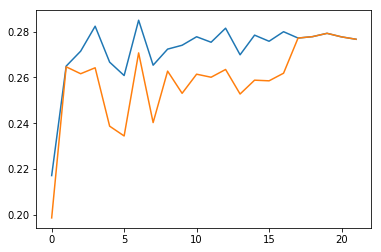

Fold: 2


6421it [00:14, 442.00it/s]
6421it [00:14, 448.57it/s]
6421it [00:14, 455.85it/s]
6421it [00:12, 519.68it/s]
6421it [00:16, 397.06it/s]
6421it [00:14, 439.79it/s]
6421it [00:13, 463.77it/s]
6421it [00:13, 475.02it/s]
6421it [00:13, 492.18it/s]
6421it [00:13, 463.89it/s]
6421it [00:13, 472.84it/s]
6421it [00:13, 473.07it/s]
6421it [00:13, 471.96it/s]
6421it [00:13, 488.37it/s]
6421it [00:13, 481.94it/s]
6421it [00:13, 482.89it/s]
6421it [00:13, 475.80it/s]


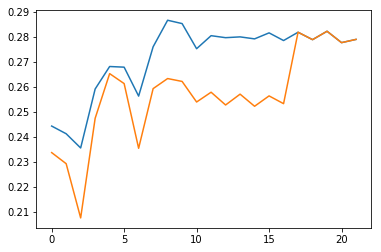

Fold: 3


6421it [00:14, 442.09it/s]
6421it [00:13, 465.76it/s]
6421it [00:13, 475.93it/s]
6421it [00:15, 422.17it/s]
6421it [00:15, 411.32it/s]
6421it [00:15, 406.51it/s]
6421it [00:15, 407.74it/s]
6421it [00:15, 412.73it/s]
6421it [00:15, 420.25it/s]
6421it [00:14, 431.55it/s]
6421it [00:15, 427.91it/s]
6421it [00:14, 442.92it/s]
6421it [00:15, 422.73it/s]
6421it [00:15, 411.82it/s]
6421it [00:14, 448.04it/s]
6421it [00:13, 458.66it/s]
6421it [00:13, 476.86it/s]


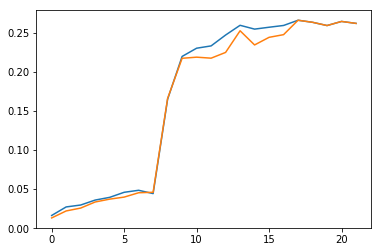

In [20]:
NB_EPOCH = 17
base_pth = '../data/models/retinanet_resnet34_no_clf/'

for fold in range(4):
    print('Fold: {}'.format(fold))
    l = pickle.load(open(os.path.join(base_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
    plt.plot([ls['iou'] for ls in l['val_losses']])
    for epoch in range(NB_EPOCH):
        bbxr, clfr = pickle.load(open(os.path.join(base_pth, 'fold_{}_checkpoint.epoch_results_{}'.format(fold, epoch)), 'rb'))
        iou = map_iou.compute_maps(df, bbxr, clfr, coeff=.22, k=2)
        l['val_losses'][epoch]['iou'] = iou[0]
    plt.plot([ls['iou'] for ls in l['val_losses']])
    plt.show()
    pickle.dump(l, open(os.path.join(base_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'wb'))


In [175]:
def get_datagens(fold, paths_df, df, class_ddf):
    paths = ds.get_paths(paths_df, root_dir=PATHS['TRAIN'])

    paths_fold, paths_rest = ds.get_fold(paths, fold=fold, nb_folds=PARAMS['NB_FOLDS'], seed=42)
    augments = augs.BBoxesAugmentation(side=512, strength=1.)
    augments_val = augs.BBoxesAugmentation(side=768, strength=0)
    dataset_train = ds.BBoxDataset(paths_rest, df, class_ddf, augmentations=augments, inverse=PARAMS['INVERSE'])
    dataset_val = ds.BBoxDataset(paths_fold, df, class_ddf, augments_val)
    esmplr = EqualizedSampler(dataset_train, class_ddf)
    vsmplr = ValSampler(dataset_val)
    train_datagen = torch.utils.data.DataLoader(dataset_train, 
                                                pin_memory=False,
                                                sampler=esmplr,
                                                collate_fn=ds.bbox_collater,
                                                batch_size=PARAMS['BATCH_SIZE'],
                                                num_workers=8)

    val_datagen = torch.utils.data.DataLoader(dataset_val,
                                              sampler=vsmplr,
                                              collate_fn=ds.bbox_collater,
                                              batch_size=PARAMS['BATCH_SIZE'] // 3,
                                              num_workers=0)
    return train_datagen, val_datagen

In [176]:
train, test = get_datagens(0, paths_df, df, ddf)

In [7]:
paths = glob(os.path.join(PATHS['TRAIN'], 'png', '*.png'))

separate = lambda x: os.path.basename(x)
paths = [separate(path) for path in paths]

paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)
paths = ds.get_paths(paths_df, root_dir=PATHS['TRAIN'], mask_dir='clipped')

In [8]:
for key, path in tqdm(paths.items()):
    break

  0%|          | 0/25684 [00:00<?, ?it/s]


In [9]:
augments = augs.Augmentation(side=512, strength=1.)
dataset = ds.CXR_Dataset(paths, augmentations=augments, inverse=3)

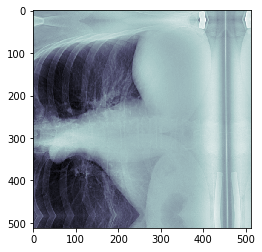

In [10]:
i = np.random.randint(len(dataset))
data = dataset[i]
plt.imshow(data['image'][0] + data['mask'][0], cmap=plt.cm.bone)

In [11]:
def get_datagens(fold, paths_df, mask_dir='masks'):
    paths = ds.get_paths(paths_df, root_dir=PATHS['TRAIN'], mask_dir=mask_dir)

    paths_fold, paths_rest = ds.get_fold(paths, fold=fold, nb_folds=PARAMS['NB_FOLDS'], seed=42)
    augments = augs.Augmentation(side=512, strength=1.)
    augments_val = augs.Augmentation(side=768, strength=0)
    dataset_train = ds.CXR_Dataset(paths_rest, augmentations=augments, inverse=PARAMS['INVERSE'])
    dataset_val = ds.CXR_Dataset(paths_fold, augments_val)

    train_datagen = torch.utils.data.DataLoader(dataset_train, 
                                                pin_memory=False,
                                                shuffle=True,
                                                batch_size=PARAMS['BATCH_SIZE'],
                                                num_workers=8)
    val_datagen = torch.utils.data.DataLoader(dataset_val,
                                              shuffle=False,
                                              batch_size=PARAMS['BATCH_SIZE'] // 3,
                                              num_workers=0)
    return train_datagen, val_datagen

In [12]:
def orchestrate(learner, train_datagen, val_datagen, 
                fold=0, epochs=1, hard_negative_miner=None,
                checkpoints_pth='../data/', lr_scheduler=None, 
                history=None, verbose=True, nb_freezed_epchs=0):

    if checkpoints_pth is not None:
        path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
    if history is None:
        history = defaultdict(list)
    try:
        os.mkdir(checkpoints_pth)
    except:
        pass
    last_epoch = len(history['train_losses'])
    print('last_epoch: {}'.format(last_epoch))

    for epoch_i in range(last_epoch, epochs):
        if hasattr(lr_scheduler, 'step'):
            lr_scheduler.step()
        learner.freeze_encoder(unfreeze=(epoch_i >= nb_freezed_epchs))

        meters = learner.train_on_epoch(
            train_datagen, 
            hard_negative_miner=hard_negative_miner,
            lr_scheduler=lr_scheduler
        )
        history['train_losses'].append(meters)

        meters = learner.validate(val_datagen)
        history['val_losses'].append(meters)

        clear_output(wait=True)
        if verbose:
            visualisation.plot_losses(history)
            learner.infer_on_data(val_datagen.dataset[577])
            learner.infer_on_data(val_datagen.dataset[896])
            learner.infer_on_data(val_datagen.dataset[314])
#             if train_dataset.aug_params['strength'] > min_strength:
#                 train_dataset.aug_strength_decay(strength_decay)

        if (checkpoints_pth is not None) and ((epoch_i) % 3 == 0):
            state_dict = learner.model.state_dict()
            if isinstance(learner.model, torch.nn.DataParallel):
                state_dict = learner.model.module.state_dict()
            torch.save(state_dict, 
                       path.format(fold, epoch_i))
            pickle.dump(history, open(path.format(fold, 'loss'), 'wb'))
            print(path.format(fold, epoch_i))

#         train_dataset.converge_appearence(decay=converge_appearence)

    return learner, history

In [13]:
loss = losses.BCEDiceJaccardLoss(
    weights={
        'bce': .7,
#         'jacc': .3,
        'dice': .3,
    },
#     chnls_w=np.array([1.] * 5 + [.1])
)
# loss = losses.FocalLoss(gamma=2, alpha=.7)

In [14]:
def one_hot_embedding(labels, num_classes):
    '''Embedding labels to one-hot form.
    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.
    Returns:
      (tensor) encoded labels, sized [N,#classes].
    '''
    y = torch.eye(num_classes)  # [D,D]
    return y[labels]            # [N,D]


def focal_loss(x, y):
    '''Focal loss.
    Args:
      x: (tensor) sized [N,D].
      y: (tensor) sized [N,].
    Return:
      (tensor) focal loss.
    '''
    alpha = .7
    gamma = 2
    y = y.view(-1)
    x = x.view(-1, 1)
    t = one_hot_embedding(y.long().data.cpu(), 2)  # [N,21]
    t = t[:,1:]  # exclude background
    t = torch.autograd.Variable(t).cuda()  # [N,20]

    p = torch.sigmoid(x)
    pt = p*t + (1-p)*(1-t)         # pt = p if t > 0 else 1-p
    w = alpha*t + (1-alpha)*(1-t)  # w = alpha if t > 0 else 1-alpha
    w = w * (1-pt).pow(gamma)
    return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)


In [15]:
last_epoch = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
}

# YOUHUU

In [ ]:
model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
model = thf.get_model(model, checkpoint='../data/models/albunet_BNdec_opac/fold_{}_checkpoint.epoch_{}'.format(fold, 10), devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

In [ ]:
pths = val_datagen.dataset.paths[val_datagen.dataset.keys[i]]
images = [cv2.imread(pths['image'], 0)]
# images += [cv2.imread(pths['inversed'].format(invid), 0) for invid in range(1, 4)]
images = [ds.img_transform(np.expand_dims(img, -1).astype(np.uint8)) for img in images]

images = torch.cat(images + [-img for img in images])
images = images.view(*(images.size(0), 1) + tuple(images.shape[1:]))

In [ ]:
images = torch.autograd.Variable(images).cuda()
pred = learner.model.forward(images)
pred = torch.sigmoid(pred).data.cpu().numpy()

o = np.median(pred, axis=0)
# cs = ax.contourf(X, Y, z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(np.squeeze(o))
ax[1].imshow(np.squeeze(o))
cs = ax[2].imshow(np.squeeze(o));
cbar = fig.colorbar(cs)
plt.show()


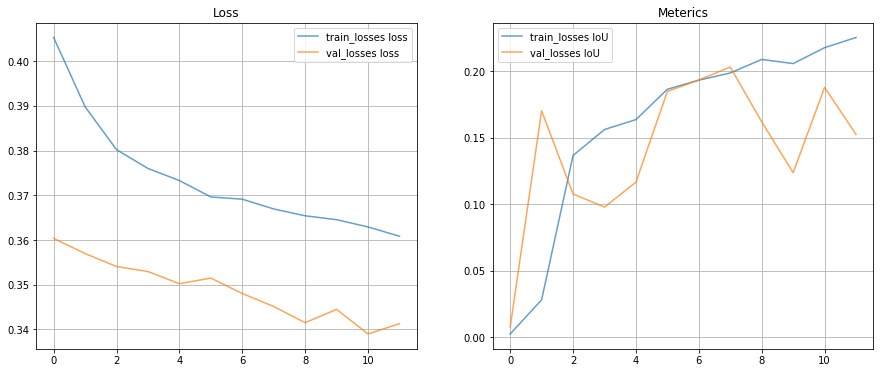

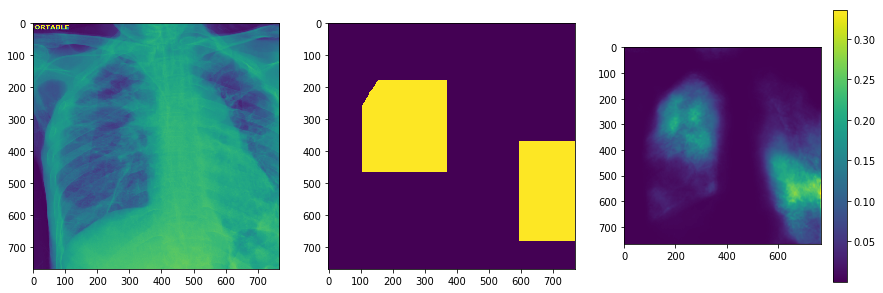

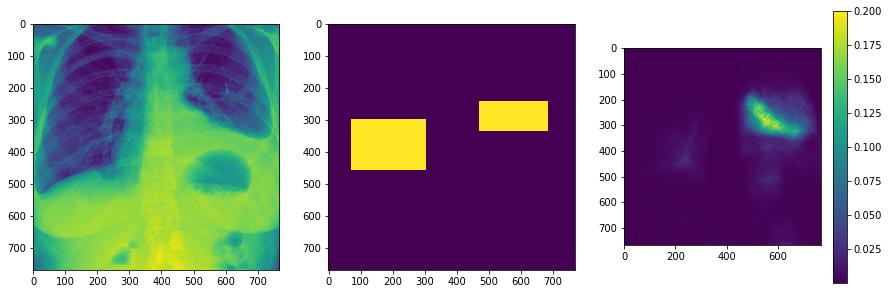

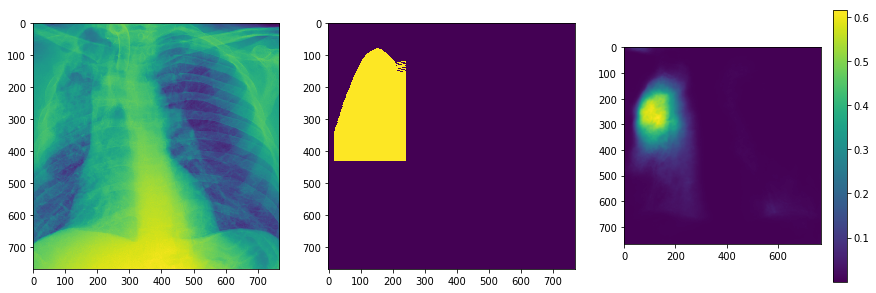

 40%|████      | 648/1606 [04:40<06:54,  2.31it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
# BCE DICE

fold = 0
train_datagen, val_datagen = get_datagens(fold, paths_df, mask_dir='clipped')

checkpoints_pth = '../data/models/albunet_BNdec_opac_bce/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
model = thf.get_model(model, checkpoint='../data/models/albunet_BNdec/fold_{}_checkpoint.epoch_{}'.format(fold, 190), devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth=checkpoints_pth,
    history=None, nb_freezed_epchs=1
)

In [18]:
# BCE DICE

fold = 0
train_datagen, val_datagen = get_datagens(fold, paths_df, mask_dir='clipped')

checkpoints_pth = '../data/models/albunet_BNdec_opac_bce/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
model = thf.get_model(model, checkpoint='../data/models/albunet_BNdec/fold_{}_checkpoint.epoch_{}'.format(fold, 190), devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=focal_loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth=checkpoints_pth,
    history=None, nb_freezed_epchs=-1
)

  0%|          | 0/1606 [00:00<?, ?it/s]

Overlapped keys: 402
last_epoch: 0


  7%|▋         | 117/1606 [01:08<14:29,  1.71it/s]Process Process-117:
Process Process-119:
Process Process-120:
Process Process-114:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-116:
  File "/home/vessemer/anaconda3/envs/cxr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/vessemer/anaconda3/envs/cxr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/vessemer/anaconda3/envs/cxr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process Process-118:
Process Process-113:
  File "/home/vessemer/anaconda3/envs/cxr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/hom

KeyboardInterrupt: 

In [ ]:
# No Pretrain

fold = 0
train_datagen, val_datagen = get_datagens(fold, paths_df, mask_dir='clipped')

checkpoints_pth = '../data/models/albunet_BNdec_opac_bce/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth=checkpoints_pth,
    history=None, nb_freezed_epchs=2
)

In [ ]:
# No Pretrain

fold = 2
train_datagen, val_datagen = get_datagens(fold, paths_df, mask_dir='clipped')

checkpoints_pth = '../data/models/albunet_BNdec_opac_bce/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth=checkpoints_pth,
    history=None, nb_freezed_epchs=2
)

In [ ]:
# No Pretrain

fold = 3
train_datagen, val_datagen = get_datagens(fold, paths_df, mask_dir='clipped')

checkpoints_pth = '../data/models/albunet_BNdec_opac_bce/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth=checkpoints_pth,
    history=None, nb_freezed_epchs=2
)

# Inference over dataset

In [105]:
import joblib

In [106]:
idir = os.path.join(PATHS['TRAIN'])
mdir = os.path.join(PATHS['TRAIN'], 'masks')
paths = glob(os.path.join(idir, 'png', '*.png'))
paths = [os.path.basename(path) for path in paths]
paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)

In [107]:
aug = lambda x: { k: cv2.resize(v, (256, 256)) for k, v in x.items() if v is not None}

In [108]:
paths = ds.get_paths(paths_df, root_dir=idir)
dataset = ds.CXR_Dataset(paths, augmentations=aug)
datagen = torch.utils.data.DataLoader(dataset,
                                      shuffle=False,
                                      batch_size=1,
                                      num_workers=0)

In [59]:
def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return np.array(mirrs)


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return origs

In [16]:
# plt.imshow((image[0, ..., 0] - ds.MEAN) / ds.STD)

In [60]:
last_iter = 190
checkpoints_pth = '../data/models/albunet_BNdec/'
checkpoints = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')

cnn_pool = list()
for fold in range(4):
    model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
    model = thf.get_model(model, checkpoint=checkpoints.format(fold, last_iter), devices=PARAMS['CUDA_DEVICES'])
    model.module.eval()
    cnn_pool.append(model)


Overlapped keys: 480
Overlapped keys: 480
Overlapped keys: 480
Overlapped keys: 480


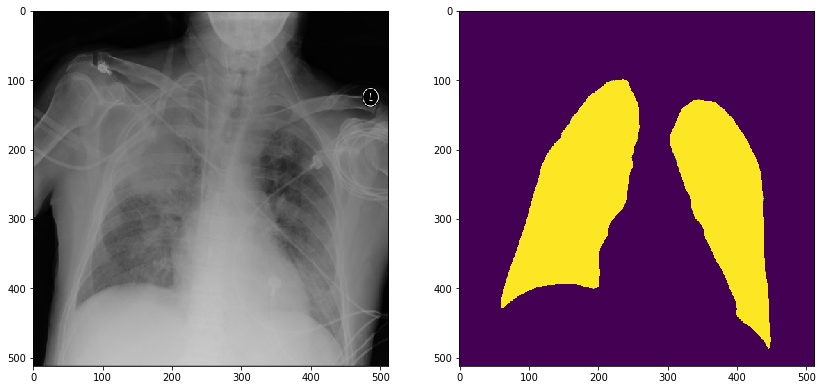

10086it [3:14:21,  1.16s/it]

In [ ]:
for i, (k, v) in tqdm(enumerate(paths.items())):
    image = cv2.imread(v['image'])
    image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
    image1 = ((255. - image[..., :1].astype(np.float)) / 255. - ds.MEAN) / ds.STD
    image2 = (image[..., :1] / 255. - ds.MEAN) / ds.STD
    images1 = _rotate_mirror_do(image1)
    images2 = _rotate_mirror_do(image2)
    images = np.concatenate([images1, images2])
    images = torch.tensor(np.rollaxis(images.astype(np.float32), 3, 1))

    with torch.no_grad():
        preds_ = list()
        images = torch.autograd.Variable(images).cuda()
        for cnn in cnn_pool:
            pred = torch.sigmoid(cnn(images))
            preds_.append(pred.data.cpu().numpy())

    preds = list()
    for pred in preds_:
        preds += _rotate_mirror_undo(np.rollaxis(pred[:8], 1, 4))
        preds += _rotate_mirror_undo(np.rollaxis(pred[8:], 1, 4))

    pred = 255 * np.median(np.array(preds) > .5, axis=0).squeeze()
    cv2.imwrite(os.path.join(mdir, k), pred.astype(np.uint8))

    if i % 100 == 0:
        clear_output()
        _, ax = plt.subplots(ncols=2, figsize=(14, 7))
        ax[0].imshow(np.squeeze(image))
        ax[1].imshow(np.squeeze(pred))
        plt.show()
